Saved one monthly CSV: D:\git20\geo-toolbox\data_out\market_with_enso_proxy_monthly.csv
                  date  ADM_PRICE   BG_PRICE  SOY_PRICE     ADM_IDX  \
date                                                                  
2025-02-28  2025-02-28  46.322712  72.914062    1011.50  600.925286   
2025-03-31  2025-03-31  47.117653  75.105713    1014.75  611.237724   
2025-04-30  2025-04-30  46.862488  77.366158    1034.75  607.927574   
2025-05-31  2025-05-31  47.859432  77.471024    1041.75  620.860519   
2025-06-30  2025-06-30  52.331070  79.582520    1024.25  678.869217   

                BG_IDX     SOY_IDX  Brazil_Temp  Brazil_Precip  USA_Temp  \
date                                                                       
2025-02-28  646.557398  213.171760         27.4          205.7      -4.7   
2025-03-31  665.991616  213.856691         27.7          161.0       7.9   
2025-04-30  686.035859  218.071654         26.8          188.0      11.7   
2025-05-31  686.965747  219.546891

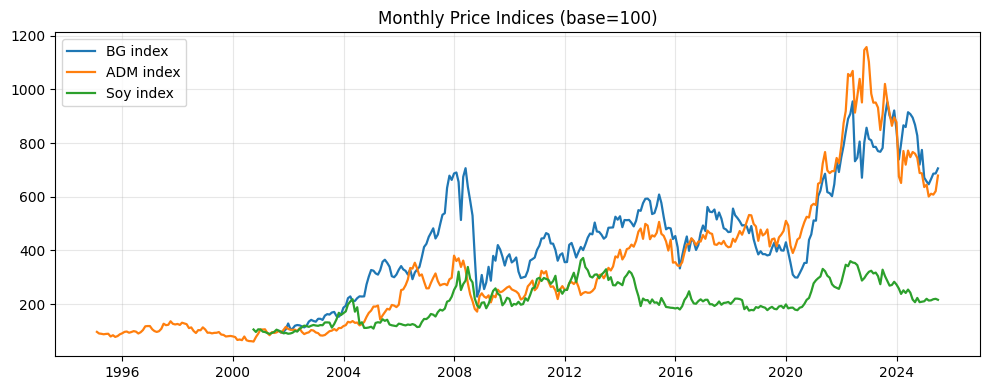

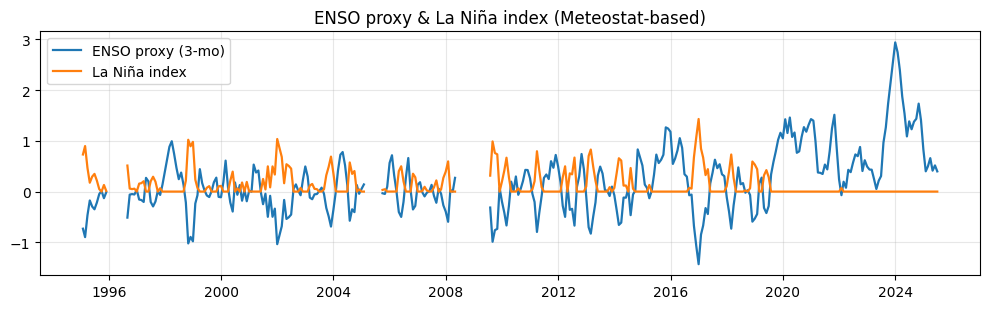

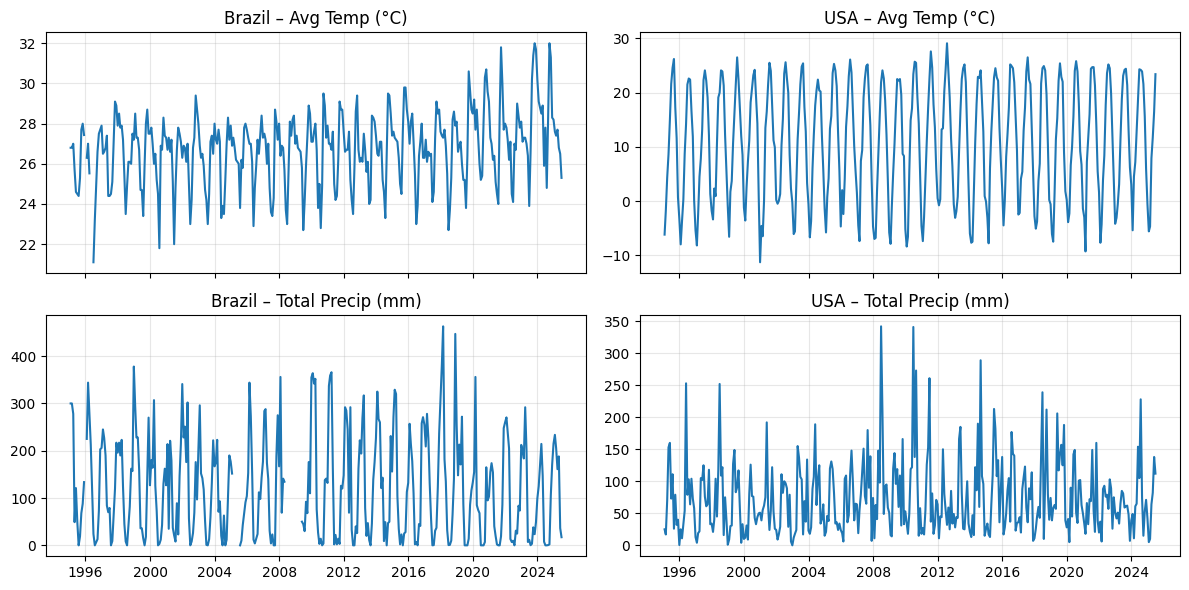

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings

# ==========================
# Config
# ==========================
START_DATE = "1995-01-01"
TICKERS = ["BG", "ADM", "ZS=F"]
RENAME_MAP = {"BG": "BG", "ADM": "ADM", "ZS=F": "SOY"}

OUT_DIR = Path("data_out")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV = OUT_DIR / "market_with_enso_proxy_monthly.csv"  # single output

# Soy regions (single point per country; no averaging)
BRAZIL_LATLON = (-15.6, -56.1)  # Cuiabá, Mato Grosso
USA_LATLON    = (41.6, -93.6)   # Des Moines, Iowa

CLIM_START, CLIM_END = 1991, 2020  # climatology base for anomalies

# ==========================
# Dependencies
# ==========================
try:
    import yfinance as yf
except ImportError as e:
    raise SystemExit("Missing yfinance. Install: pip install yfinance") from e

try:
    from meteostat import Monthly, Point
except ImportError as e:
    raise SystemExit("Missing meteostat. Install: pip install meteostat") from e

warnings.filterwarnings("ignore", category=FutureWarning)

# ==========================
# Helpers
# ==========================
def last_full_month_end() -> pd.Timestamp:
    """Return last day of the most recent completed month (tz-naive)."""
    today = pd.Timestamp.utcnow().normalize()
    first = today.replace(day=1)
    last = (first - pd.Timedelta(days=1)).normalize()
    return pd.Timestamp(last).tz_localize(None)

def ensure_naive_index(df: pd.DataFrame) -> pd.DataFrame:
    if isinstance(df.index, pd.DatetimeIndex) and df.index.tz is not None:
        df = df.copy()
        df.index = df.index.tz_convert(None)
    return df

def to_base100_df(prices_df: pd.DataFrame) -> pd.DataFrame:
    """Index = 100 at first common month across columns."""
    base_idx = prices_df.dropna().index.min()
    if pd.isna(base_idx):
        out = pd.DataFrame(index=prices_df.index)
        for c in prices_df.columns:
            s = prices_df[c].dropna()
            out[c] = 100 * (prices_df[c] / s.iloc[0]) if not s.empty else np.nan
        return out
    base_row = prices_df.loc[base_idx]
    return 100 * (prices_df / base_row)

# ==========================
# Prices → Monthly
# ==========================
def build_prices_monthly() -> pd.DataFrame:
    end_m = last_full_month_end()
    data = yf.download(
        TICKERS,
        start=START_DATE,
        end=(end_m + pd.Timedelta(days=1)),
        auto_adjust=True,
        progress=False,
    )
    data = ensure_naive_index(data)

    if isinstance(data.columns, pd.MultiIndex):
        close = data["Close"].copy()
    else:
        close = data[["Close"]].copy()
        close.columns = TICKERS

    close = close[[c for c in close.columns if c in RENAME_MAP]].rename(columns=RENAME_MAP)
    close = ensure_naive_index(close)

    monthly_close = close.resample("M").last().dropna(how="all")
    monthly_index = to_base100_df(monthly_close)

    prices = monthly_close.rename(columns=lambda c: f"{c}_PRICE").join(
        monthly_index.rename(columns=lambda c: f"{c}_IDX")
    )
    prices.index = prices.index.tz_localize(None)
    prices.index.name = "date"
    return prices

# ==========================
# Meteostat: Temp & Precip (Monthly)
# ==========================
def load_temp_precip_monthly(points: dict) -> pd.DataFrame:
    """
    Returns DF (index = month-end) with columns:
      '[Name]_Temp' (°C), '[Name]_Precip' (mm).
    """
    pieces = []
    for name, (lat, lon) in points.items():
        df = Monthly(Point(lat, lon), pd.Timestamp(1990, 1, 1), last_full_month_end()).fetch()
        if df.empty:
            print(f"[WARN] Meteostat empty for: {name}")
            continue
        # normalize index to month-end, tz-naive
        df.index = (pd.to_datetime(df.index) + pd.offsets.MonthEnd(0)).tz_localize(None)

        # light interpolation to bridge single-month gaps
        df["tavg"] = pd.to_numeric(df.get("tavg"), errors="coerce").interpolate(limit=1)
        df["prcp"] = pd.to_numeric(df.get("prcp"), errors="coerce").interpolate(limit=1)

        part = pd.DataFrame(index=df.index)
        if "tavg" in df.columns:
            part[f"{name}_Temp"] = df["tavg"]
        if "prcp" in df.columns:
            part[f"{name}_Precip"] = df["prcp"]
        pieces.append(part)

    if not pieces:
        return pd.DataFrame()

    out = pd.concat(pieces, axis=1).sort_index()
    out.index.name = "date"
    return out

# ==========================
# ENSO Proxy from Meteostat (Monthly)
# ==========================
def monthwise_anomalies(series: pd.Series, clim_start=CLIM_START, clim_end=CLIM_END) -> pd.DataFrame:
    """
    Month-by-month anomalies & z-scores using climatology over [clim_start, clim_end].
    Adds epsilon for zero-std months to avoid NaNs.
    """
    s = series.copy()
    df = s.to_frame("val")
    df["month"] = df.index.month
    base = df[(df.index.year >= clim_start) & (df.index.year <= clim_end)]
    clim = base.groupby("month")["val"].agg(["mean", "std"]).rename(columns={"mean": "clim", "std": "sd"})
    EPS = 1e-6
    clim["sd"] = clim["sd"].replace(0, EPS)

    anom = []
    zvals = []
    for ts, row in df.iterrows():
        m = row["month"]
        mu = clim.loc[m, "clim"] if m in clim.index else np.nan
        sd = clim.loc[m, "sd"] if m in clim.index else np.nan
        a = row["val"] - mu if pd.notna(mu) else np.nan
        z = (a / sd) if (pd.notna(a) and pd.notna(sd)) else np.nan
        anom.append(a); zvals.append(z)

    out = pd.DataFrame({"anom": anom, "z": zvals}, index=df.index).sort_index()
    return out

def build_enso_proxy_from_meteostat(point: Point) -> pd.DataFrame:
    """
    ENSO proxy:
      enso_proxy_raw = (z_temp - z_prcp)/2
      enso_proxy     = 3-month rolling mean (min_periods=3; strict ONI-like)
      enso_phase     = El Niño-like / La Niña-like / Neutral
      la_nina_index  = max(0, -enso_proxy)
    """
    start = pd.Timestamp(1990, 1, 1)
    end = last_full_month_end()
    df = Monthly(point, start, end).fetch()
    if df.empty:
        raise RuntimeError("Meteostat returned empty series for ENSO-proxy point.")

    df.index = (pd.to_datetime(df.index) + pd.offsets.MonthEnd(0)).tz_localize(None)

    # Light interpolation for single-month gaps
    tavg = pd.to_numeric(df.get("tavg"), errors="coerce").interpolate(limit=1)
    prcp = pd.to_numeric(df.get("prcp"), errors="coerce").interpolate(limit=1)

    # Monthwise anomalies / z-scores
    t = monthwise_anomalies(tavg)
    p = monthwise_anomalies(prcp)

    proxy = pd.DataFrame(index=df.index)
    proxy["enso_proxy_raw"] = (t["z"] - p["z"]) / 2.0
    proxy["enso_proxy"] = proxy["enso_proxy_raw"].rolling(3, min_periods=3).mean()

    def classify(x: float):
        if pd.isna(x): return np.nan
        if x >= 0.5:   return "El Niño-like"
        if x <= -0.5:  return "La Niña-like"
        return "Neutral"

    proxy["enso_phase"] = proxy["enso_proxy"].apply(classify)
    proxy["la_nina_index"] = proxy["enso_proxy"].apply(lambda x: max(0.0, -x) if pd.notna(x) else np.nan)
    proxy.index.name = "date"
    return proxy[["enso_proxy", "enso_phase", "la_nina_index"]]

# ==========================
# Build & Save ONE CSV
# ==========================
if __name__ == "__main__":
    # 1) Prices
    prices_m = build_prices_monthly()

    # 2) Weather (temp/precip for Brazil & USA)
    weather_tp = load_temp_precip_monthly({
        "Brazil": BRAZIL_LATLON,
        "USA": USA_LATLON
    })

    # 3) ENSO proxy (Brazil point)
    enso_proxy = build_enso_proxy_from_meteostat(Point(*BRAZIL_LATLON))

    # 4) Align to common monthly range to avoid dangling NaNs
    idx_common = prices_m.index
    if not weather_tp.empty:
        idx_common = idx_common.intersection(weather_tp.index)
    if not enso_proxy.empty:
        idx_common = idx_common.intersection(enso_proxy.index)

    prices_m = prices_m.loc[idx_common]
    weather_tp = weather_tp.loc[idx_common] if not weather_tp.empty else weather_tp
    enso_proxy = enso_proxy.loc[idx_common] if not enso_proxy.empty else enso_proxy

    # 5) Merge & save
    monthly_out = prices_m.join([weather_tp, enso_proxy], how="outer").sort_index()
    monthly_out.index = pd.to_datetime(monthly_out.index).tz_localize(None)
    monthly_out.index.name = "date"

    monthly_out_csv = monthly_out.copy()
    monthly_out_csv.insert(0, "date", monthly_out_csv.index.strftime("%Y-%m-%d"))
    monthly_out_csv.to_csv(OUT_CSV, index=False, float_format="%.3f")

    print(f"Saved one monthly CSV: {OUT_CSV.resolve()}")
    print(monthly_out_csv.tail())

    # ==========================
    # Quick plots
    # ==========================
    # Price indices
    plt.figure(figsize=(10, 4))
    for col, label in [("BG_IDX", "BG index"), ("ADM_IDX", "ADM index"), ("SOY_IDX", "Soy index")]:
        if col in monthly_out.columns:
            plt.plot(monthly_out.index, monthly_out[col], linewidth=1.6, label=label)
    plt.title("Monthly Price Indices (base=100)")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    # ENSO proxy + La Niña index
    plt.figure(figsize=(10, 3.2))
    if "enso_proxy" in monthly_out.columns:
        plt.plot(monthly_out.index, monthly_out["enso_proxy"], label="ENSO proxy (3-mo)", linewidth=1.6)
    if "la_nina_index" in monthly_out.columns:
        plt.plot(monthly_out.index, monthly_out["la_nina_index"], label="La Niña index", linewidth=1.6)
    plt.title("ENSO proxy & La Niña index (Meteostat-based)")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    # Temp / Precip panels
    fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
    axes = axes.flatten()
    if "Brazil_Temp" in monthly_out.columns:
        axes[0].plot(monthly_out.index, monthly_out["Brazil_Temp"]); axes[0].set_title("Brazil – Avg Temp (°C)"); axes[0].grid(alpha=0.3)
    if "USA_Temp" in monthly_out.columns:
        axes[1].plot(monthly_out.index, monthly_out["USA_Temp"]); axes[1].set_title("USA – Avg Temp (°C)"); axes[1].grid(alpha=0.3)
    if "Brazil_Precip" in monthly_out.columns:
        axes[2].plot(monthly_out.index, monthly_out["Brazil_Precip"]); axes[2].set_title("Brazil – Total Precip (mm)"); axes[2].grid(alpha=0.3)
    if "USA_Precip" in monthly_out.columns:
        axes[3].plot(monthly_out.index, monthly_out["USA_Precip"]); axes[3].set_title("USA – Total Precip (mm)"); axes[3].grid(alpha=0.3)
    plt.tight_layout(); plt.show()


HTTP Error 404: 

1 Failed download:
['FCPO1!']: YFTzMissingError('possibly delisted; no timezone found')
HTTP Error 404: 

1 Failed download:
['FCPOC1']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['KPOC1']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['FBMPM.L']: YFPricesMissingError('possibly delisted; no price data found  (1d 1995-01-01 -> 2025-09-01 00:00:00)')

1 Failed download:
['FBMPM.FGI']: YFPricesMissingError('possibly delisted; no price data found  (1d 1995-01-01 -> 2025-09-01 00:00:00)')

1 Failed download:
['FBMPMP.FGI']: YFPricesMissingError('possibly delisted; no price data found  (1d 1995-01-01 -> 2025-09-01 00:00:00)')


Resolved tickers (logical_name: yahoo_symbol):
  BG: BG
  ADM: ADM
  SOY: ZS=F
  BRLUSD: BRLUSD=X
  USDBRL: USDBRL=X
  USDCNY: USDCNY=X
  CNYUSD: CNYUSD=X
  DXY: ^NYICDX
  WTI: CL=F
  BRENT: BZ=F
  CORN: ZC=F
  WHEAT: ZW=F
  BDI: BDI
  GRAIN_FREIGHT: BGX
Saved one monthly CSV: D:\git20\geo-toolbox\data_out\market_with_enso_proxy_monthly.csv


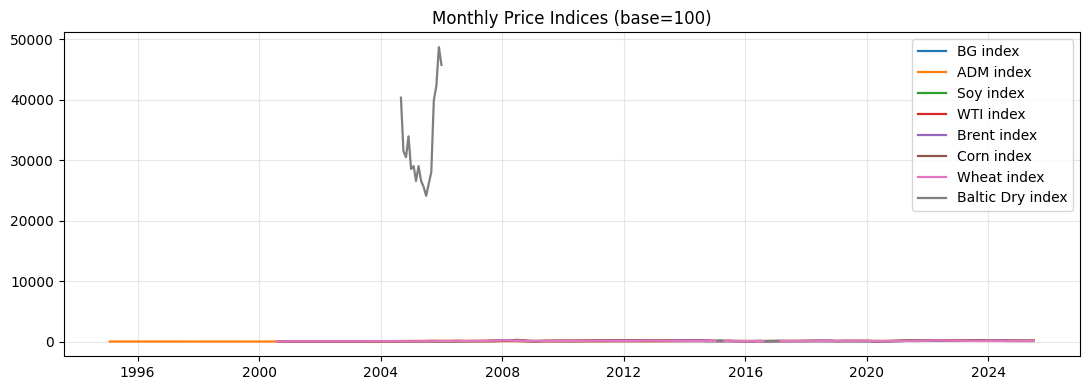

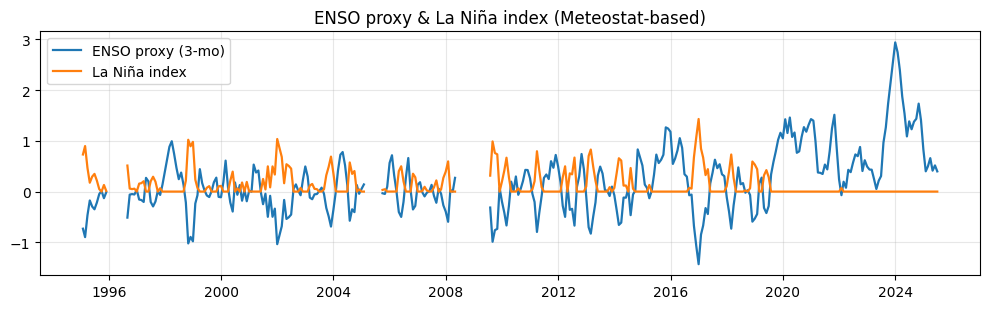

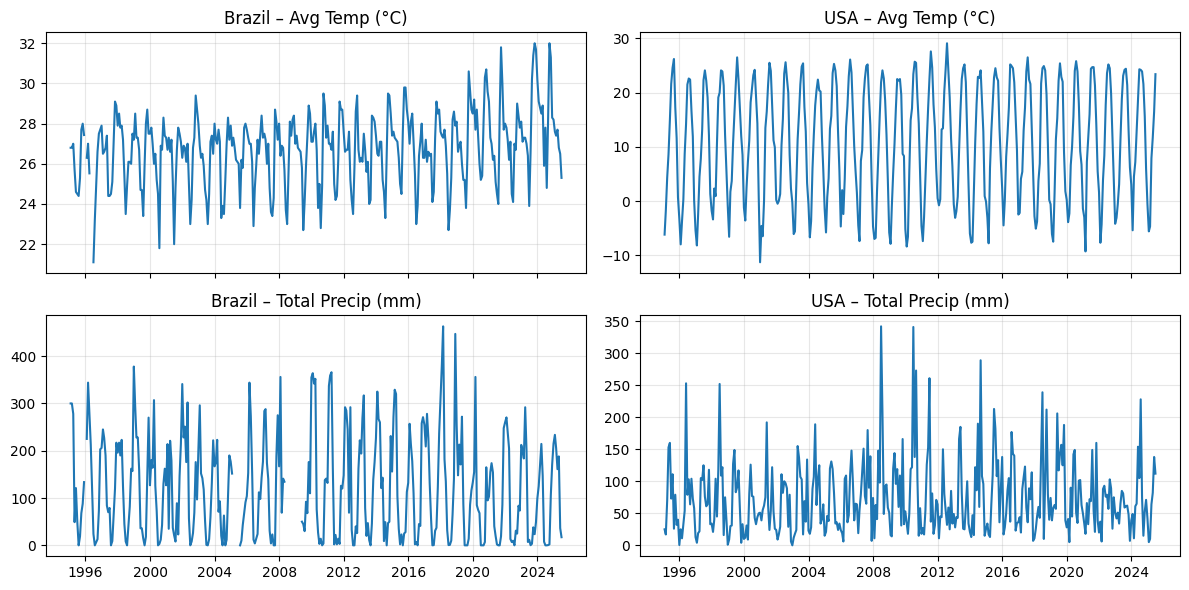

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings

# ==========================
# Config
# ==========================
START_DATE = "1995-01-01"

# Logical series → candidate Yahoo tickers (first that works wins)
CANDIDATES = {
    # Equities / soy already in your script
    "BG": ["BG"],
    "ADM": ["ADM"],
    "SOY": ["ZS=F"],  # CBOT Soybeans

    # FX
    "BRLUSD": ["BRLUSD=X", "BRL/ USD"],  # direct BRLUSD if available; otherwise we'll build from USDBRL
    "USDBRL": ["USDBRL=X", "BRL=X"],     # Yahoo usually uses BRL=X for USD/BRL
    "USDCNY": ["USDCNY=X", "CNY=X"],
    "CNYUSD": ["CNYUSD=X"],

    # Dollar index
    "DXY": ["^NYICDX", "DX-Y.NYB", "DX=F"],

    # Energy
    "WTI": ["CL=F"],
    "BRENT": ["BZ=F", "BZT=F"],

    # Palm oil (Yahoo coverage is spotty; try several, else will skip)
    # Prefer futures continuous if present; otherwise broad Malaysian plantation index as a rough proxy
    "PALM": ["FCPO1!", "FCPOc1", "KPOc1", "FBMPM.L", "FBMPM.FGI", "FBMPMP.FGI"],

    # Grains
    "CORN": ["ZC=F"],
    "WHEAT": ["ZW=F"],

    # Freight
    "BDI": ["BDI", "^BDI"],  # Baltic Dry Index
    # Grain freight (rarely on Yahoo). If unavailable, we use BDRY ETF as a proxy so you at least get something
    "GRAIN_FREIGHT": ["BGX", "BPI", "BDRY"],
}

RENAME_MAP = {
    # Equities / soy
    "BG": "BG",
    "ADM": "ADM",
    "ZS=F": "SOY",

    # FX & DXY (resolved later when we normalize logical names)
}

OUT_DIR = Path("data_out")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV = OUT_DIR / "market_with_enso_proxy_monthly.csv"  # single output

# Soy regions (single point per country; no averaging)
BRAZIL_LATLON = (-15.6, -56.1)  # Cuiabá, Mato Grosso
USA_LATLON    = (41.6, -93.6)   # Des Moines, Iowa

CLIM_START, CLIM_END = 1991, 2020  # climatology base for anomalies

# ==========================
# Dependencies
# ==========================
try:
    import yfinance as yf
except ImportError as e:
    raise SystemExit("Missing yfinance. Install: pip install yfinance") from e

try:
    from meteostat import Monthly, Point
except ImportError as e:
    raise SystemExit("Missing meteostat. Install: pip install meteostat") from e

warnings.filterwarnings("ignore", category=FutureWarning)

# ==========================
# Helpers
# ==========================
def last_full_month_end() -> pd.Timestamp:
    """Return last day of the most recent completed month (tz-naive)."""
    today = pd.Timestamp.utcnow().normalize()
    first = today.replace(day=1)
    last = (first - pd.Timedelta(days=1)).normalize()
    return pd.Timestamp(last).tz_localize(None)


def ensure_naive_index(df: pd.DataFrame) -> pd.DataFrame:
    if isinstance(df.index, pd.DatetimeIndex) and df.index.tz is not None:
        df = df.copy()
        df.index = df.index.tz_convert(None)
    return df


def to_base100_df(prices_df: pd.DataFrame) -> pd.DataFrame:
    """Index = 100 at first common month across columns."""
    base_idx = prices_df.dropna().index.min()
    if pd.isna(base_idx):
        out = pd.DataFrame(index=prices_df.index)
        for c in prices_df.columns:
            s = prices_df[c].dropna()
            out[c] = 100 * (prices_df[c] / s.iloc[0]) if not s.empty else np.nan
        return out
    base_row = prices_df.loc[base_idx]
    return 100 * (prices_df / base_row)


def fetch_one(symbols):
    """Try a list of Yahoo tickers; return the first successfully-downloaded Close series.
    Returns (series, used_symbol) or (None, None) if none worked.
    """
    if isinstance(symbols, str):
        symbols = [symbols]
    end_m = last_full_month_end() + pd.Timedelta(days=1)
    for sym in symbols:
        try:
            df = yf.download(sym, start=START_DATE, end=end_m, auto_adjust=True, progress=False)
            if df is None or df.empty:
                continue
            # If it's a single series, df will have standard OHLCV columns
            s = df["Close"].copy()
            s.name = sym
            s.index = pd.to_datetime(s.index)
            s = s.resample("M").last()
            if s.dropna().empty:
                continue
            return s, sym
        except Exception:
            continue
    return None, None


def build_logical_series():
    """Download all logical series defined in CANDIDATES, build necessary transforms, and
    return a monthly price dataframe with harmonized names.
    """
    out = {}
    used = {}

    # First pass: try to fetch each logical series
    for name, syms in CANDIDATES.items():
        s, used_sym = fetch_one(syms)
        if s is not None:
            out[name] = s
            used[name] = used_sym

    # Build BRLUSD if only USDBRL exists
    if "BRLUSD" not in out and "USDBRL" in out:
        s = out["USDBRL"].copy()
        out["BRLUSD"] = 1.0 / s
        used["BRLUSD"] = f"inverse_of:{used.get('USDBRL','USDBRL')}"

    # Build CNYUSD if only USDCNY exists (and vice versa)
    if "CNYUSD" not in out and "USDCNY" in out:
        out["CNYUSD"] = 1.0 / out["USDCNY"]
        used["CNYUSD"] = f"inverse_of:{used.get('USDCNY','USDCNY')}"
    if "USDCNY" not in out and "CNYUSD" in out:
        out["USDCNY"] = 1.0 / out["CNYUSD"]
        used["USDCNY"] = f"inverse_of:{used.get('CNYUSD','CNYUSD')}"

    # Align into a single DataFrame
    if not out:
        return pd.DataFrame(), {}
    df = pd.concat(out.values(), axis=1)
    df.columns = list(out.keys())
    df = df.sort_index()

    # Create *_PRICE and *_IDX columns (base=100)
    price_cols = {}
    for col in df.columns:
        price_cols[f"{col}_PRICE"] = df[col]
    price_df = pd.DataFrame(price_cols)

    idx_df = to_base100_df(price_df)
    idx_df.columns = [c.replace("_PRICE", "_IDX") for c in idx_df.columns]

    prices = price_df.join(idx_df)
    prices.index.name = "date"

    return prices, used


# ==========================
# Original Prices (BG/ADM/SOY) kept for compatibility
# but now sourced via the logical series table above too.
# ==========================
def build_prices_monthly() -> pd.DataFrame:
    prices, _ = build_logical_series()
    return prices


# ==========================
# Meteostat: Temp & Precip (Monthly)
# ==========================
def load_temp_precip_monthly(points: dict) -> pd.DataFrame:
    """
    Returns DF (index = month-end) with columns:
      '[Name]_Temp' (°C), '[Name]_Precip' (mm).
    """
    pieces = []
    for name, (lat, lon) in points.items():
        df = Monthly(Point(lat, lon), pd.Timestamp(1990, 1, 1), last_full_month_end()).fetch()
        if df.empty:
            print(f"[WARN] Meteostat empty for: {name}")
            continue
        # normalize index to month-end, tz-naive
        df.index = (pd.to_datetime(df.index) + pd.offsets.MonthEnd(0)).tz_localize(None)

        # light interpolation to bridge single-month gaps
        df["tavg"] = pd.to_numeric(df.get("tavg"), errors="coerce").interpolate(limit=1)
        df["prcp"] = pd.to_numeric(df.get("prcp"), errors="coerce").interpolate(limit=1)

        part = pd.DataFrame(index=df.index)
        if "tavg" in df.columns:
            part[f"{name}_Temp"] = df["tavg"]
        if "prcp" in df.columns:
            part[f"{name}_Precip"] = df["prcp"]
        pieces.append(part)

    if not pieces:
        return pd.DataFrame()

    out = pd.concat(pieces, axis=1).sort_index()
    out.index.name = "date"
    return out


# ==========================
# ENSO Proxy from Meteostat (Monthly)
# ==========================
def monthwise_anomalies(series: pd.Series, clim_start=CLIM_START, clim_end=CLIM_END) -> pd.DataFrame:
    """
    Month-by-month anomalies & z-scores using climatology over [clim_start, clim_end].
    Adds epsilon for zero-std months to avoid NaNs.
    """
    s = series.copy()
    df = s.to_frame("val")
    df["month"] = df.index.month
    base = df[(df.index.year >= clim_start) & (df.index.year <= clim_end)]
    clim = base.groupby("month")["val"].agg(["mean", "std"]).rename(columns={"mean": "clim", "std": "sd"})
    EPS = 1e-6
    clim["sd"] = clim["sd"].replace(0, EPS)

    anom = []
    zvals = []
    for ts, row in df.iterrows():
        m = row["month"]
        mu = clim.loc[m, "clim"] if m in clim.index else np.nan
        sd = clim.loc[m, "sd"] if m in clim.index else np.nan
        a = row["val"] - mu if pd.notna(mu) else np.nan
        z = (a / sd) if (pd.notna(a) and pd.notna(sd)) else np.nan
        anom.append(a); zvals.append(z)

    out = pd.DataFrame({"anom": anom, "z": zvals}, index=df.index).sort_index()
    return out


def build_enso_proxy_from_meteostat(point: Point) -> pd.DataFrame:
    """
    ENSO proxy:
      enso_proxy_raw = (z_temp - z_prcp)/2
      enso_proxy     = 3-month rolling mean (min_periods=3; strict ONI-like)
      enso_phase     = El Niño-like / La Niña-like / Neutral
      la_nina_index  = max(0, -enso_proxy)
    """
    start = pd.Timestamp(1990, 1, 1)
    end = last_full_month_end()
    df = Monthly(point, start, end).fetch()
    if df.empty:
        raise RuntimeError("Meteostat returned empty series for ENSO-proxy point.")

    df.index = (pd.to_datetime(df.index) + pd.offsets.MonthEnd(0)).tz_localize(None)

    # Light interpolation for single-month gaps
    tavg = pd.to_numeric(df.get("tavg"), errors="coerce").interpolate(limit=1)
    prcp = pd.to_numeric(df.get("prcp"), errors="coerce").interpolate(limit=1)

    # Monthwise anomalies / z-scores
    t = monthwise_anomalies(tavg)
    p = monthwise_anomalies(prcp)

    proxy = pd.DataFrame(index=df.index)
    proxy["enso_proxy_raw"] = (t["z"] - p["z"]) / 2.0
    proxy["enso_proxy"] = proxy["enso_proxy_raw"].rolling(3, min_periods=3).mean()

    def classify(x: float):
        if pd.isna(x): return np.nan
        if x >= 0.5:   return "El Niño-like"
        if x <= -0.5:  return "La Niña-like"
        return "Neutral"

    proxy["enso_phase"] = proxy["enso_proxy"].apply(classify)
    proxy["la_nina_index"] = proxy["enso_proxy"].apply(lambda x: max(0.0, -x) if pd.notna(x) else np.nan)
    proxy.index.name = "date"
    return proxy[["enso_proxy", "enso_phase", "la_nina_index"]]


# ==========================
# Build & Save ONE CSV
# ==========================
if __name__ == "__main__":
    # 1) Prices & indices (includes FX, DXY, WTI/Brent, Palm proxy, Corn/Wheat, Freight)
    prices_m, used_symbols = build_logical_series()

    # 2) Weather (temp/precip for Brazil & USA)
    weather_tp = load_temp_precip_monthly({
        "Brazil": BRAZIL_LATLON,
        "USA": USA_LATLON
    })

    # 3) ENSO proxy (Brazil point)
    enso_proxy = build_enso_proxy_from_meteostat(Point(*BRAZIL_LATLON))

    # 4) Align to common monthly range to avoid dangling NaNs
    idx_common = prices_m.index if not prices_m.empty else None
    if not weather_tp.empty:
        idx_common = weather_tp.index if idx_common is None else idx_common.intersection(weather_tp.index)
    if not enso_proxy.empty:
        idx_common = enso_proxy.index if idx_common is None else idx_common.intersection(enso_proxy.index)

    if idx_common is None:
        idx_common = pd.DatetimeIndex([])

    prices_m = prices_m.loc[idx_common] if not prices_m.empty else prices_m
    weather_tp = weather_tp.loc[idx_common] if not weather_tp.empty else weather_tp
    enso_proxy = enso_proxy.loc[idx_common] if not enso_proxy.empty else enso_proxy

    # 5) Merge & save
    monthly_out = prices_m.join([weather_tp, enso_proxy], how="outer").sort_index()
    monthly_out.index = pd.to_datetime(monthly_out.index).tz_localize(None)
    monthly_out.index.name = "date"

    monthly_out_csv = monthly_out.copy()
    monthly_out_csv.insert(0, "date", monthly_out_csv.index.strftime("%Y-%m-%d"))
    OUT_CSV.parent.mkdir(parents=True, exist_ok=True)
    monthly_out_csv.to_csv(OUT_CSV, index=False, float_format="%.3f")

    # Report which symbols were used (printed to console)
    print("Resolved tickers (logical_name: yahoo_symbol):")
    for k, v in used_symbols.items():
        print(f"  {k}: {v}")

    print(f"Saved one monthly CSV: {OUT_CSV.resolve()}")

    # ==========================
    # Quick plots (only if data available)
    # ==========================
    # Price indices (selected)
    plt.figure(figsize=(11, 4))
    for col, label in [
        ("BG_IDX", "BG index"),
        ("ADM_IDX", "ADM index"),
        ("SOY_IDX", "Soy index"),
        ("WTI_IDX", "WTI index"),
        ("BRENT_IDX", "Brent index"),
        ("CORN_IDX", "Corn index"),
        ("WHEAT_IDX", "Wheat index"),
        ("BDI_IDX", "Baltic Dry index"),
    ]:
        if col in monthly_out.columns:
            plt.plot(monthly_out.index, monthly_out[col], linewidth=1.6, label=label)
    plt.title("Monthly Price Indices (base=100)")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    # ENSO proxy + La Niña index
    plt.figure(figsize=(10, 3.2))
    if "enso_proxy" in monthly_out.columns:
        plt.plot(monthly_out.index, monthly_out["enso_proxy"], label="ENSO proxy (3-mo)", linewidth=1.6)
    if "la_nina_index" in monthly_out.columns:
        plt.plot(monthly_out.index, monthly_out["la_nina_index"], label="La Niña index", linewidth=1.6)
    plt.title("ENSO proxy & La Niña index (Meteostat-based)")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    # Temp / Precip panels
    fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
    axes = axes.flatten()
    if "Brazil_Temp" in monthly_out.columns:
        axes[0].plot(monthly_out.index, monthly_out["Brazil_Temp"]); axes[0].set_title("Brazil – Avg Temp (°C)"); axes[0].grid(alpha=0.3)
    if "USA_Temp" in monthly_out.columns:
        axes[1].plot(monthly_out.index, monthly_out["USA_Temp"]); axes[1].set_title("USA – Avg Temp (°C)"); axes[1].grid(alpha=0.3)
    if "Brazil_Precip" in monthly_out.columns:
        axes[2].plot(monthly_out.index, monthly_out["Brazil_Precip"]); axes[2].set_title("Brazil – Total Precip (mm)"); axes[2].grid(alpha=0.3)
    if "USA_Precip" in monthly_out.columns:
        axes[3].plot(monthly_out.index, monthly_out["USA_Precip"]); axes[3].set_title("USA – Total Precip (mm)"); axes[3].grid(alpha=0.3)
    plt.tight_layout(); plt.show()
